Found 10 available trajectory files for CHARMM36m_TIP3P
Loading 10 trajectories for CHARMM36m_TIP3P...
 Loaded trajectory 1
 Loaded trajectory 2
 Loaded trajectory 3
 Loaded trajectory 4
 Loaded trajectory 5
 Loaded trajectory 6
 Loaded trajectory 7
 Loaded trajectory 8
 Loaded trajectory 9
 Loaded trajectory 10
Successfully loaded 10 trajectories
Combined shape: (10, 50000, 21)
Fitting IVAC model...
  Lag range: 10-100 steps
  Eigenvectors: 20


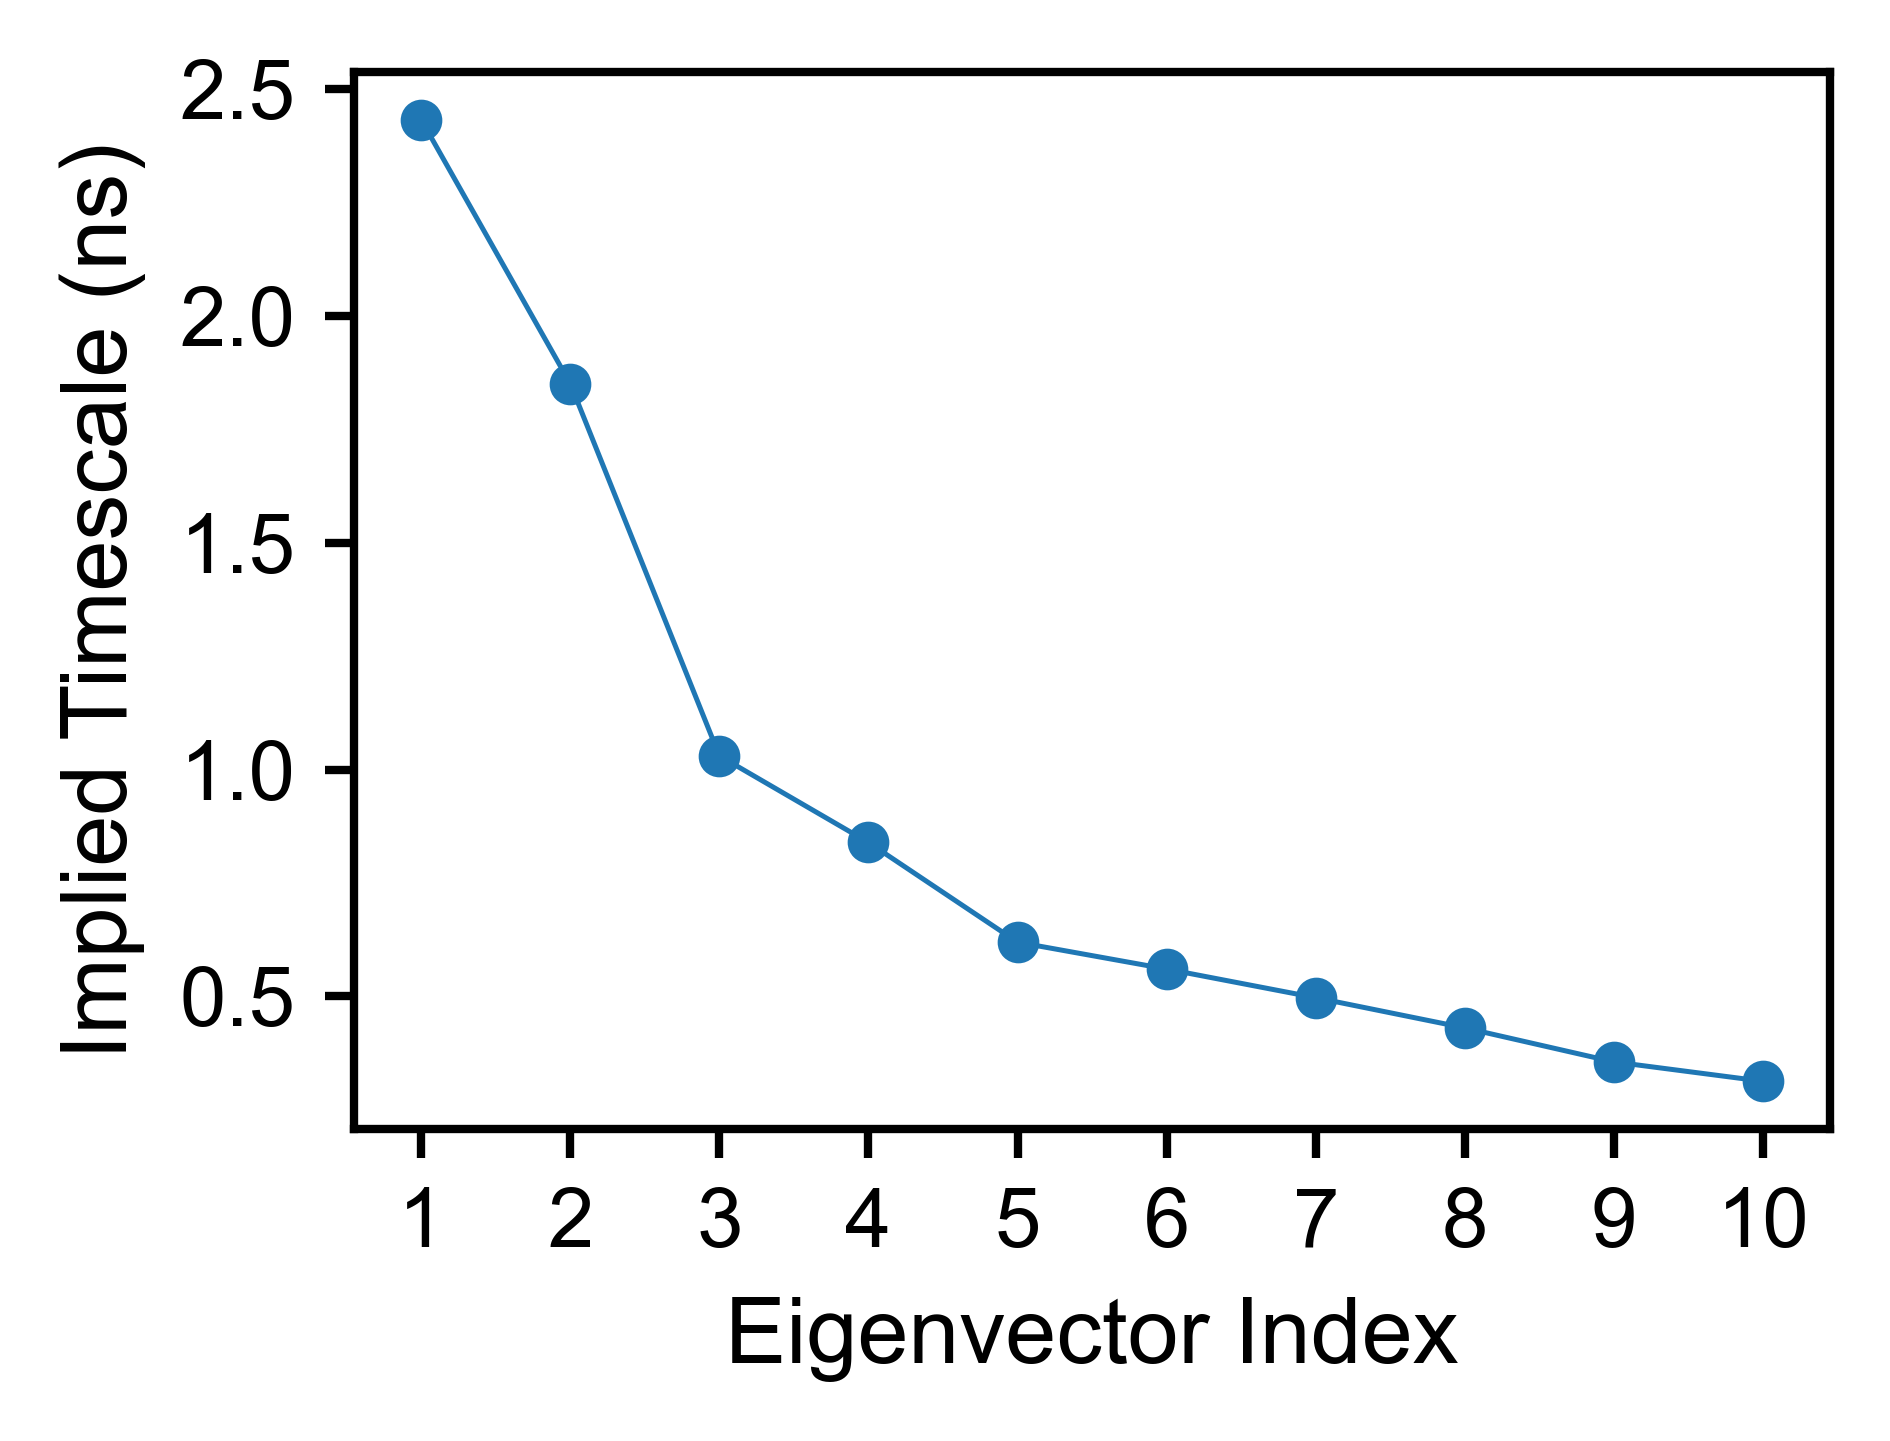


IVAC ANALYSIS SUMMARY
Force Field: CHARMM36m_TIP3P
Trajectories: 10
Lag Range: 0.1–1 ns
Eigenvectors: 20
Finite Timescales: 21
Longest Timescale: 2.432 ns
Shortest Timescale: 0.065 ns

IVAC analysis completed successfully!


In [1]:
### PLOTS IMPLIED TIMESCALES FOR IVAC APPLIED ON 10 us CHARMM36m TRAJECTORY (FIG S03) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ivac import LinearIVAC

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
FEAT_DIR = BASE_DIR / 'ivac' / 'feat'

# Data Specifications
FORCE_FIELD = 'CHARMM36m_TIP3P'
NUM_TRAJECTORIES = 10

# Analysis Parameters
CONV = 100 # conversion factor from frame save rate of the simulation (every 10 ps) to ns
MIN_LAG = 0.1
MAX_LAG = 1
N_EIGENVECTORS = 20
IVAC_SETTINGS = {
    'reweight': True,
    'addones': True,
    'method': 'fft',
    'adjust': True
}

# Plotting Specifications
PLOT_N_TIMESCALES = 10 # plot the first 10 eigenvectors
FIGURE_SIZE = (3.25, 2.5)
DPI = 600

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def list_available_trajectories():
    """List trajectory files matching the force field pattern."""
    pattern = f'C_feat_{FORCE_FIELD}_*.npy'
    available_files = sorted([f.name for f in FEAT_DIR.glob(pattern)])
    print(f"Found {len(available_files)} available trajectory files for {FORCE_FIELD}")
    return available_files

def load_all_trajectories():
    """Load and combine all trajectory feature files."""
    trajectories = []
    print(f"Loading {NUM_TRAJECTORIES} trajectories for {FORCE_FIELD}...")
    
    for i in range(1, NUM_TRAJECTORIES + 1):
        filename = f'C_feat_{FORCE_FIELD}_{i}.npy'
        filepath = FEAT_DIR / filename
        
        if filepath.exists():
            trajectory = np.load(filepath)
            trajectories.append(trajectory)
            print(f" Loaded trajectory {i}")
        else:
            print(f" Warning: Trajectory file not found: {filepath}")
    
    if not trajectories:
        raise RuntimeError("No trajectory files were successfully loaded")
    
    combined_trajectories = np.stack(trajectories, axis=0)
    print(f"Successfully loaded {len(trajectories)} trajectories")
    print(f"Combined shape: {combined_trajectories.shape}")
    
    return combined_trajectories

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def run_ivac_analysis(data):
    """Fit IVAC model and return timescales."""
    print("Fitting IVAC model...")
    
    # Convert lag times to steps
    min_lag_steps = int(CONV * MIN_LAG)
    max_lag_steps = int(CONV * MAX_LAG)
    
    print(f"  Lag range: {min_lag_steps}-{max_lag_steps} steps")
    print(f"  Eigenvectors: {N_EIGENVECTORS}")
    
    # Initialize and fit IVAC
    ivac = LinearIVAC(
        min_lag_steps, 
        max_lag_steps, 
        nevecs=N_EIGENVECTORS, 
        **IVAC_SETTINGS
    )
    
    ivac.fit(data)
    
    # Return implied timescales (excluding the first one which is infinity for the constant feature)
    timescales = ivac.its[1:]
    
    return ivac, timescales

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def plot_timescales(timescales_ns):
    """Plot IVAC timescales vs eigenvector index."""
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    x_values = range(1, len(timescales_ns) + 1)
    
    ax.plot(x_values, timescales_ns, marker='o', linewidth=0.6, markersize=4)
    ax.set_xlabel('Eigenvector Index')
    ax.set_ylabel('Implied Timescale (ns)')
    ax.set_xticks(x_values)
    
    plt.tight_layout()
    plt.show()

def print_analysis_summary(ivac_obj, timescales):
    """Print summary of IVAC analysis parameters and results."""
    print("\n" + "="*50)
    print("IVAC ANALYSIS SUMMARY")
    print("="*50)
    print(f"Force Field: {FORCE_FIELD}")
    print(f"Trajectories: {NUM_TRAJECTORIES}")
    print(f"Lag Range: {MIN_LAG}–{MAX_LAG} ns")
    print(f"Eigenvectors: {N_EIGENVECTORS}")
    print(f"Finite Timescales: {len(timescales)}")
    print(f"Longest Timescale: {timescales[0]/CONV:.3f} ns")
    print(f"Shortest Timescale: {timescales[-1]/CONV:.3f} ns")
    print("="*50)

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to run IVAC analysis and generate timescales plot."""
    set_plot_style()
    
    try:
        # List available files
        available_files = list_available_trajectories()
        
        # Load trajectory data
        data = load_all_trajectories()
        
        # Run IVAC analysis
        ivac_obj, timescales = run_ivac_analysis(data)
        
        # Convert timescales to nanoseconds and select subset for plotting
        timescales_to_plot = timescales[:PLOT_N_TIMESCALES] / CONV
        
        # Create plot
        plot_timescales(timescales_to_plot)
        
        # Print summary
        print_analysis_summary(ivac_obj, timescales)
        print("\nIVAC analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during IVAC analysis: {e}")
        raise

if __name__ == "__main__":
    main()